In [2]:
import itertools

import numpy as np
import pandas as pd
import arviz as az
from election_results import congressional_district_results_2020
from demographics import congressional_district_demographics
az.style.use('arviz-darkgrid')

In [3]:
list(congressional_district_demographics.columns)

['Total Population',
 'Median household income in the past 12 months (in 2019 inflation-adjusted dollars)',
 'UNITS IN STRUCTURE:Total',
 'Male Population',
 'Male Population: Under 5 years',
 'Male Population: 5 to 9 years',
 'Male Population: 10 to 14 years',
 'Male Population: 15 to 17 years',
 'Male Population: 18 and 19 years',
 'Male Population: 20 years',
 'Male Population: 21 years',
 'Male Population: 22 to 24 years',
 'Male Population: 25 to 29 years',
 'Male Population: 30 to 34 years',
 'Male Population: 35 to 39 years',
 'Male Population: 40 to 44 years',
 'Male Population: 45 to 49 years',
 'Male Population: 50 to 54 years',
 'Male Population: 55 to 59 years',
 'Male Population: 60 and 61 years',
 'Male Population: 62 to 64 years',
 'Male Population: 65 and 66 years',
 'Male Population: 67 to 69 years',
 'Male Population: 70 to 74 years',
 'Male Population: 75 to 79 years',
 'Male Population: 80 to 84 years',
 'Male Population: 85 years and over',
 'Female Population:',
 

In [4]:
congressional_district_demographics = congressional_district_demographics[~congressional_district_demographics['Cook PVI'].isna()]

In [5]:
congressional_district_results_2020['Republican'].isna().sum()

19

In [6]:
congressional_district_results_2020['Republican']

Location
Alabama-01      64.4
Alabama-02      65.2
Alabama-03      67.5
Alabama-04      82.2
Alabama-05      95.8
                ... 
Wisconsin-05    60.1
Wisconsin-06    59.2
Wisconsin-07    60.7
Wisconsin-08    64.2
Wyoming-00      68.6
Name: Republican, Length: 435, dtype: float64

In [7]:
parties = ['Democratic', 'Republican', 'Libertarian', 'Green']

In [8]:
# Get rid of NaN
for party in parties:
    congressional_district_results_2020[party]=congressional_district_results_2020[party].fillna(0)
congressional_district_results_2020['Republican']

Location
Alabama-01      64.4
Alabama-02      65.2
Alabama-03      67.5
Alabama-04      82.2
Alabama-05      95.8
                ... 
Wisconsin-05    60.1
Wisconsin-06    59.2
Wisconsin-07    60.7
Wisconsin-08    64.2
Wyoming-00      68.6
Name: Republican, Length: 435, dtype: float64

In [9]:
congressional_district_results_2020['Republican']['California-03']

45.3

In [10]:
districts = pd.concat([congressional_district_demographics,congressional_district_results_2020], axis=1)

In [11]:
districts[parties].isna().sum()


Democratic     0
Republican     0
Libertarian    0
Green          0
dtype: int64

In [12]:
districts = districts.rename(columns={'Male Population':'MalePopulation', 'Cook PVI': 'CookPVI'})
for party in parties:
    districts[party] = districts[party]/100

In [13]:
districts['CookPVI'].std(),districts['CookPVI'].mean()

(16.92072948759266, -0.4367816091954023)

In [14]:
from bambi import Model, Prior

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [15]:
## Let's do a Bernoulli distribution instead. For each district, we'll make 100 trials, with the correct proportion of Rep and Dem.
feature_columns = ['CookPVI', 'MalePopulation']
abbreviated = districts[feature_columns+list(parties)]

total = 1000
for party in parties:
    abbreviated[party+'_y'] = abbreviated[party].apply(lambda x:int(x*total))
abbreviated['n'] = total

/var/folders/zy/yx7hnqcj12l_tr6nnprm66kh0000gn/T/ipykernel_81725/2170453890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbreviated[party+'_y'] = abbreviated[party].apply(lambda x:int(x*total))
/var/folders/zy/yx7hnqcj12l_tr6nnprm66kh0000gn/T/ipykernel_81725/2170453890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbreviated[party+'_y'] = abbreviated[party].apply(lambda x:int(x*total))
/var/folders/zy/yx7hnqcj12l_tr6nnprm66kh0000gn/T/ipykernel_81725/2170453890.py:7: SettingWithCopyWarning: 
A

In [16]:
import itertools
def get_district_composite(name, dist):
    total = 100
    rep = int(total*dist['Republican'])
    dem = int(total*dist['Democratic'])
    lib = int(total*dist['Libertarian'])
    grn = int(total*dist['Green'])
    ind = total-rep-dem-lib-grn
    assert ind>=0, (total, rep, dem, lib, grn)

    party_counts = [int(total*dist[party]) for party in parties]
    ind = total-sum(party_counts)
    individuals = list(itertools.chain(*[[party]*count for party, count in zip(list(parties)+['Independent'], party_counts + [ind])]))
    return pd.DataFrame(
        {
            'location': [name] * total,
            'CookPVI': [dist['CookPVI']] * total,
            'MalePopulation': [dist['MalePopulation']] * total,
            'Party': individuals,
        }
    )

total_composite = pd.concat([get_district_composite(name, dist) for name, dist in abbreviated.iterrows()])

In [17]:
total_composite

,location,CookPVI,MalePopulation,Party
0,California-03,-5.0,0.482083,Democratic
1,California-03,-5.0,0.482083,Democratic
2,California-03,-5.0,0.482083,Democratic
3,California-03,-5.0,0.482083,Democratic
4,California-03,-5.0,0.482083,Democratic
...,...,...,...,...
95,New York-05,-34.0,0.474684,Democratic
96,New York-05,-34.0,0.474684,Democratic
97,New York-05,-34.0,0.474684,Democratic
98,New York-05,-34.0,0.474684,Democratic


In [127]:
model_bernoulli = Model("Party['Republican'] ~ MalePopulation + CookPVI", total_composite, family='bernoulli')
model_bernoulli.set_priors({'MalePopulation': Prior('Beta', alpha=2, beta=2),
                            'CookPVI': Prior('Normal', mu=0, sigma=16)})

In [128]:
model_bernoulli

Formula: Party['Republican'] ~ MalePopulation + CookPVI
Family name: Bernoulli
Link: logit
Observations: 43500
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 131.4178)
    MalePopulation ~ Beta(alpha: 2, beta: 2)
    CookPVI ~ Normal(mu: 0, sigma: 16)

In [129]:
results_bernoulli = model_bernoulli.fit(draws=5000)

Modeling the probability that Party==Republican
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CookPVI, MalePopulation, Intercept]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 64 seconds.


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'CookPVI'}>,
       <AxesSubplot:title={'center':'MalePopulation'}>], dtype=object)

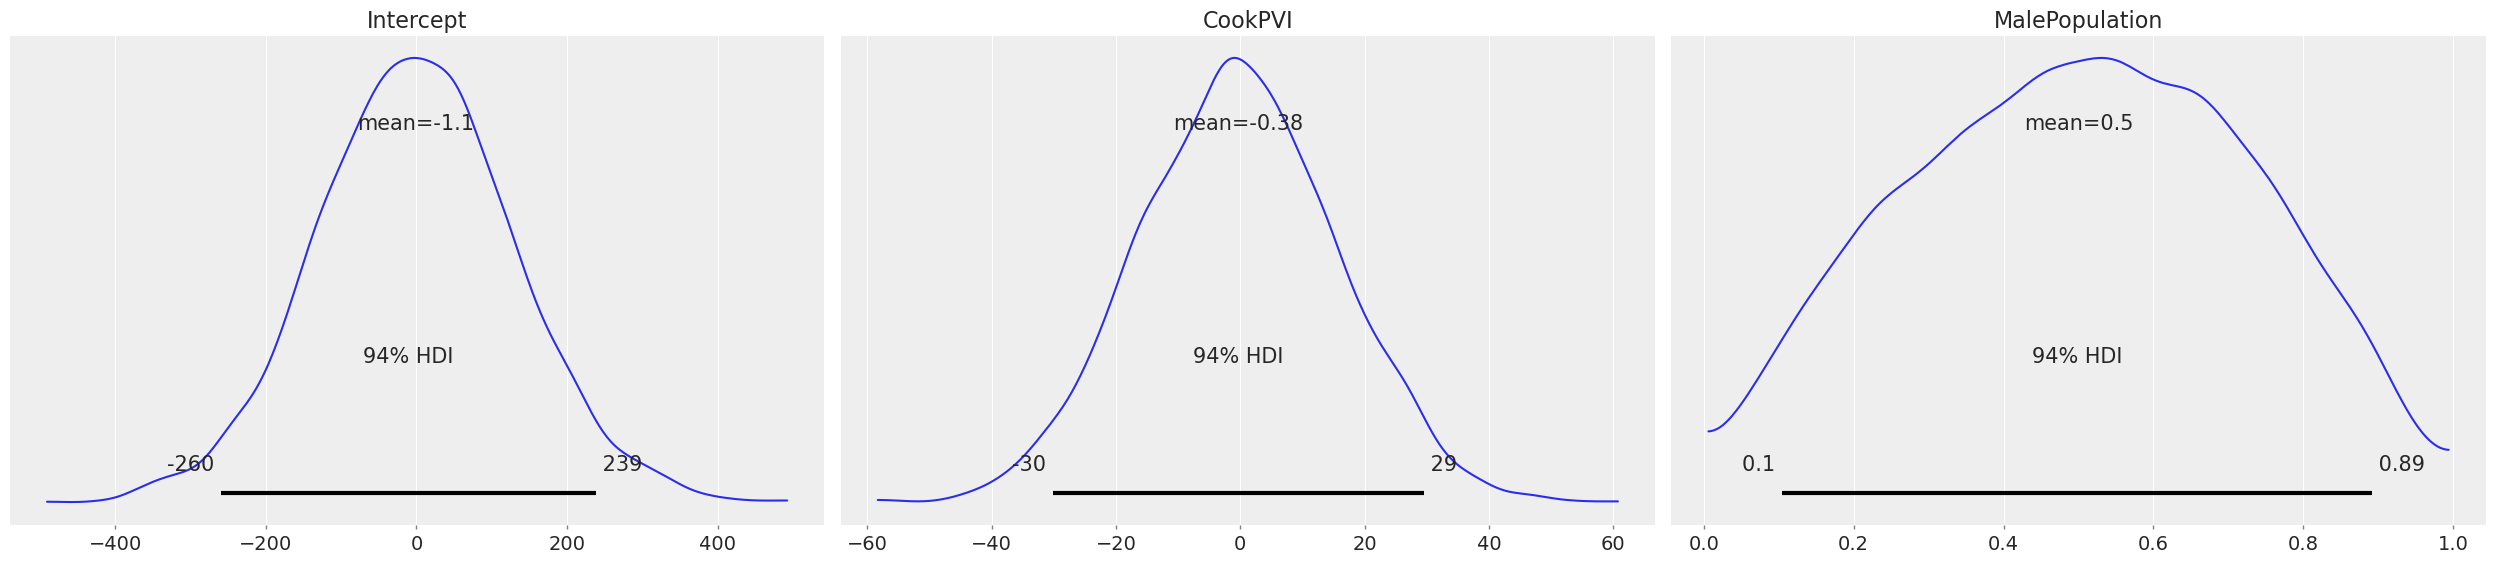

In [130]:
model_bernoulli.plot_priors()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'CookPVI'}>,
        <AxesSubplot:title={'center':'CookPVI'}>],
       [<AxesSubplot:title={'center':'MalePopulation'}>,
        <AxesSubplot:title={'center':'MalePopulation'}>]], dtype=object)

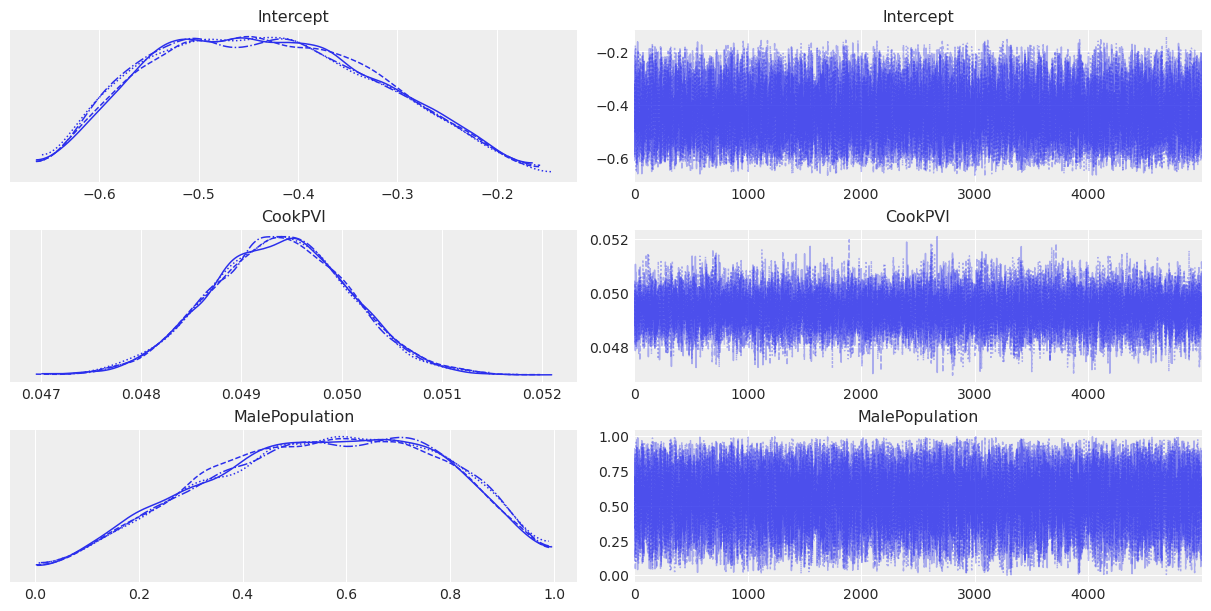

In [131]:
az.plot_trace(results_bernoulli)

In [132]:
az.summary(results_bernoulli)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.432,0.109,-0.621,-0.234,0.001,0.001,23844.0,14134.0,1.0
CookPVI,0.049,0.001,0.048,0.051,0.000,0.000,24707.0,14964.0,1.0
MalePopulation,0.553,0.220,0.170,0.949,0.001,0.001,24118.0,14003.0,1.0


In [ ]:
model_bernoulli.predict(results_bernoulli, kind="pps")
results_bernoulli

In [148]:
az.plot_ppc(results_bernoulli, kind='scatter')


TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

In [ ]:
male_pop = np.linspace(0,1,100)
mean = results_bernoulli.posterior
az.plot_hdi()

In [134]:
results_bernoulli.posterior

<xarray.Dataset>
Dimensions:         (chain: 4, draw: 5000)
Coordinates:
  * chain           (chain) int64 0 1 2 3
  * draw            (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    Intercept       (chain, draw) float64 -0.4309 -0.302 ... -0.2078 -0.2181
    CookPVI         (chain, draw) float64 0.04901 0.04944 ... 0.05116 0.0486
    MalePopulation  (chain, draw) float64 0.5569 0.3022 0.1091 ... 0.108 0.1331
Attributes:
    created_at:                  2022-01-29T00:53:48.201963
    arviz_version:               0.11.4
    inference_library:           pymc3
    inference_library_version:   3.11.4
    sampling_time:               64.16233611106873
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.7.1

In [18]:
model_binomial= Model("p(Republican_y,n) ~ MalePopulation + CookPVI", abbreviated, family='binomial')
model_binomial.set_priors({'MalePopulation': Prior('Beta', alpha=2, beta=2),
                            'CookPVI': Prior('Normal', mu=0, sigma=16)})

In [19]:
model_binomial

Formula: p(Republican_y,n) ~ MalePopulation + CookPVI
Family name: Binomial
Link: logit
Observations: 435
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 131.4178)
    MalePopulation ~ Beta(alpha: 2, beta: 2)
    CookPVI ~ Normal(mu: 0, sigma: 16)

In [20]:
results_binomial = model_binomial.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CookPVI, MalePopulation, Intercept]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'CookPVI'}>,
       <AxesSubplot:title={'center':'MalePopulation'}>], dtype=object)

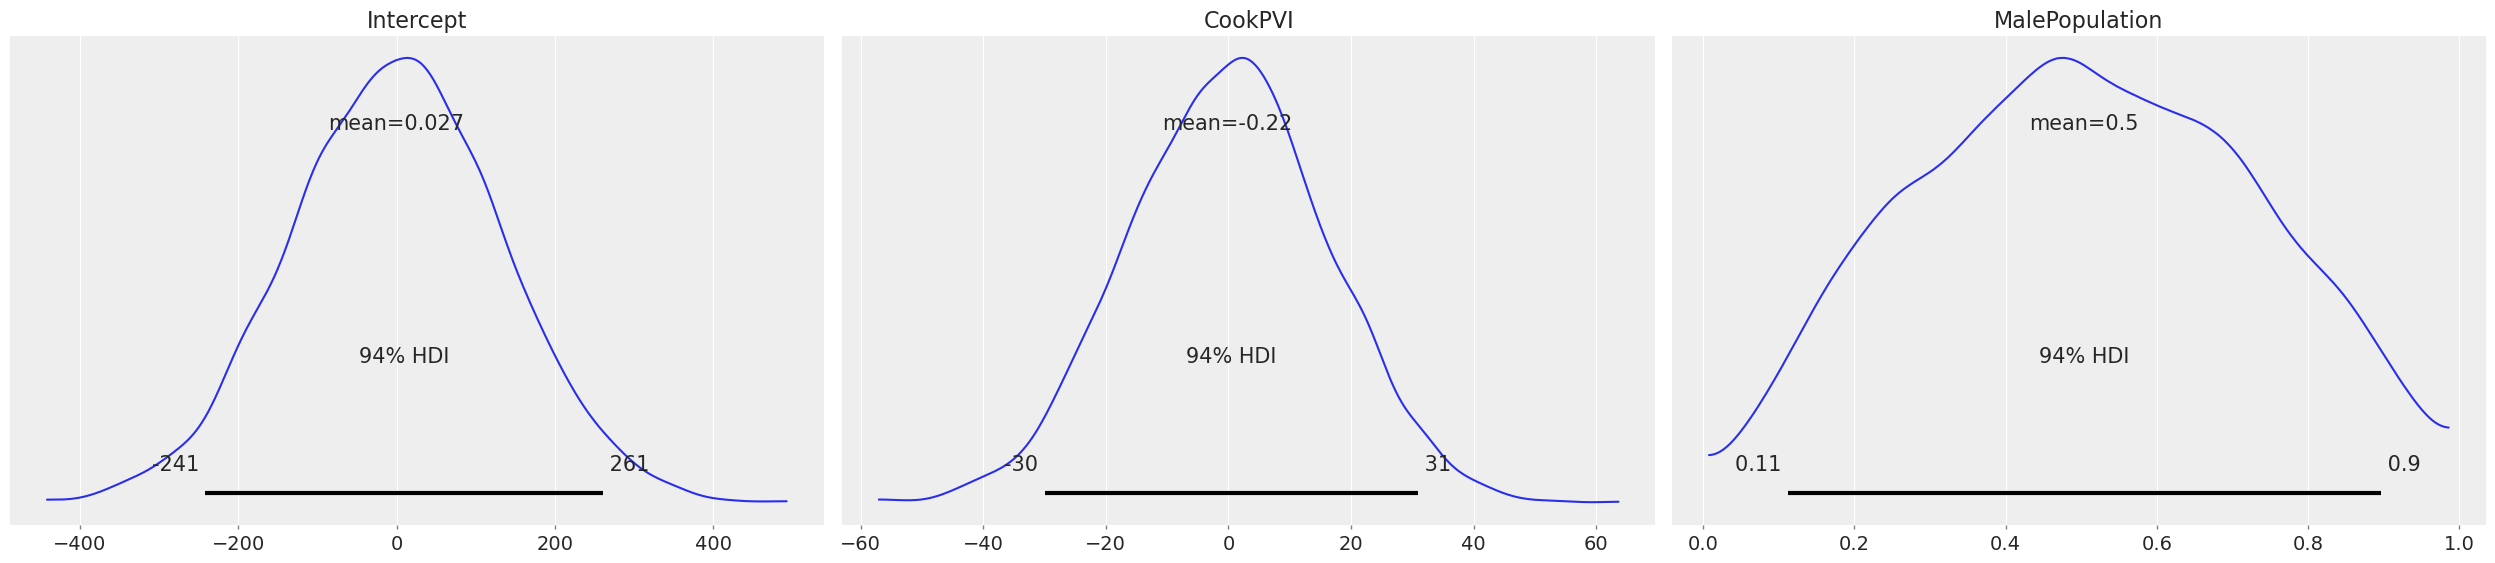

In [21]:
model_binomial.plot_priors()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'CookPVI'}>,
        <AxesSubplot:title={'center':'CookPVI'}>],
       [<AxesSubplot:title={'center':'MalePopulation'}>,
        <AxesSubplot:title={'center':'MalePopulation'}>]], dtype=object)

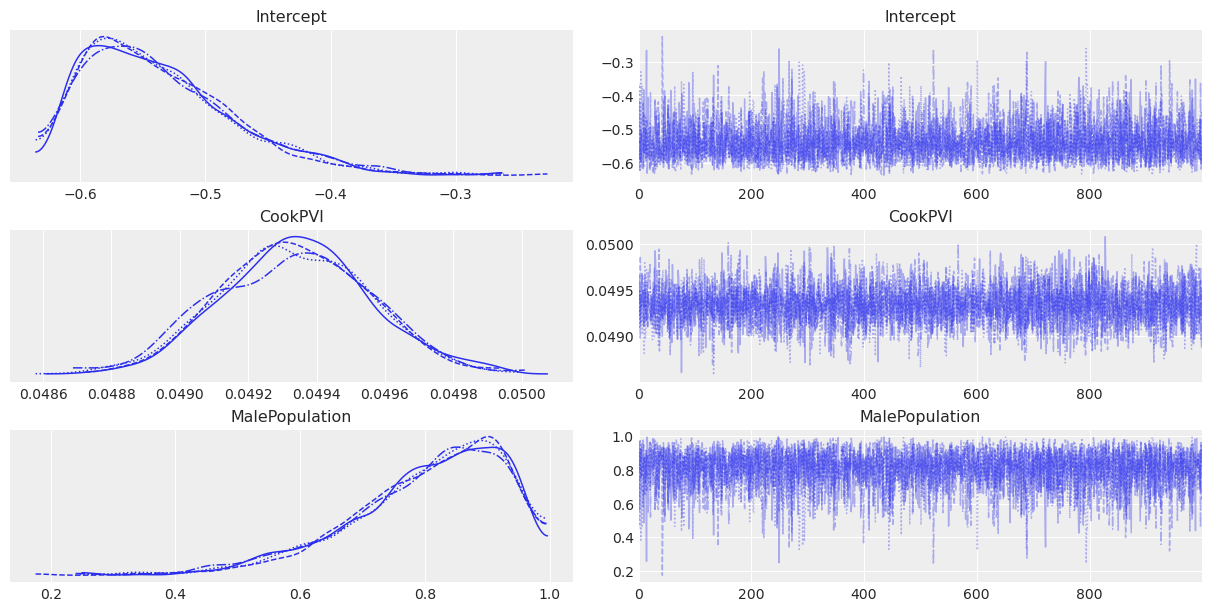

In [22]:
az.plot_trace(results_binomial)

In [23]:
az.summary(results_binomial)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.536,0.060,-0.629,-0.423,0.001,0.001,4588.0,2641.0,1.0
CookPVI,0.049,0.000,0.049,0.050,0.000,0.000,5458.0,3274.0,1.0
MalePopulation,0.804,0.122,0.578,0.988,0.002,0.001,4578.0,2772.0,1.0


In [24]:
model_binomial.predict(results_binomial, kind='pps')


KeyError: 'drawstyle'

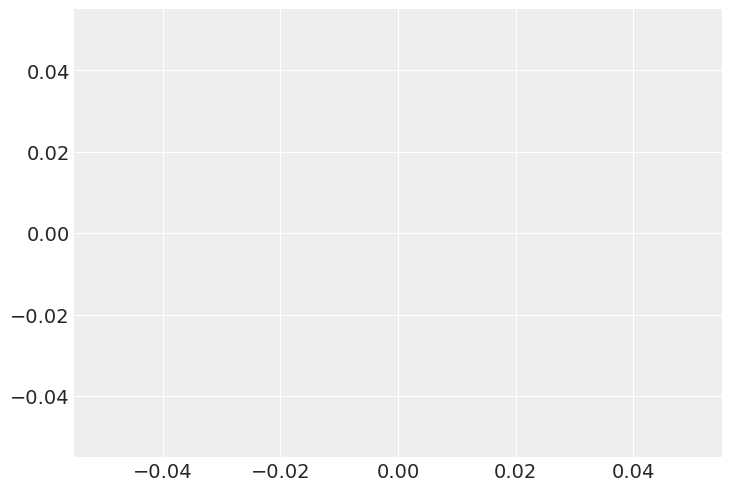

In [185]:
az.plot_ppc(results_binomial)


In [25]:
hdi_binomial = az.hdi(results_binomial)


In [166]:
az.plot_hdi(results_binomial.posterior_predictive.to_array(), hdi_binomial.to_array())

TypeError: Dimension mismatch for x: (1, 1, 1) and hdi: (435, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible

Text(0, 0.5, 'P(Republican | PVI=10)')

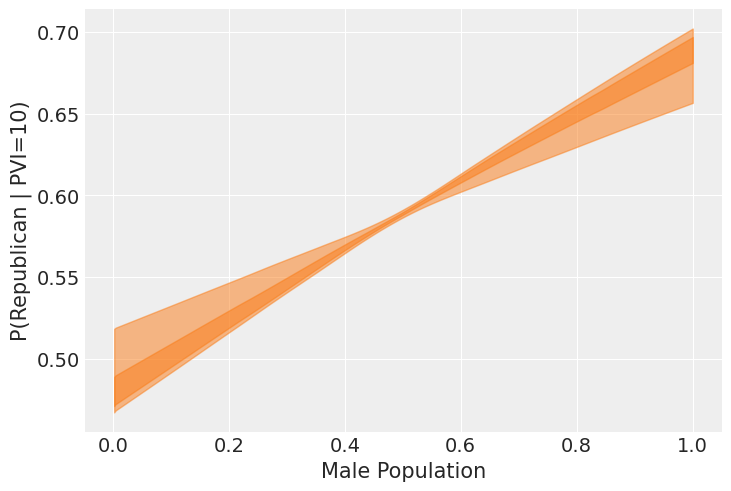

In [26]:
import matplotlib.pyplot as plt
male_pop = np.linspace(0,1,100)
new_data = pd.DataFrame({
    'CookPVI': [10]*len(male_pop),
    'MalePopulation': male_pop
})
new_idata = model_binomial.predict(results_binomial, data=new_data, inplace=False)
mean = new_idata.posterior['p(Republican_y, n)_mean'].values
fig, ax = plt.subplots()
az.plot_hdi(male_pop, mean, ax=ax)
az.plot_hdi(male_pop, mean, ax=ax, hdi_prob=0.5)
ax.set_xlabel('Male Population')
ax.set_ylabel('P(Republican | PVI=10)')

In [27]:
pvi = np.linspace(-50,50,250)
new_data2 = pd.DataFrame({
    'CookPVI': pvi,
    'MalePopulation': [.5]*len(pvi)
})
new_idata2 = model_binomial.predict(results_binomial, data=new_data2, inplace=False)
mean2 = new_idata2.posterior['p(Republican_y, n)_mean'].values
fig, ax = plt.subplots()
az.plot_hdi(pvi, mean2, ax=ax)
az.plot_hdi(pvi, mean2, ax=ax, hdi_prob=0.5)
ax.set_xlabel('PVI')
ax.set_ylabel('P(Republican | MalePopulation=.5)')

ValueError: Dataset does not contain the dimensions: {'p(Republican_y, n)_mean_obs'}

In [28]:
# Final combined model
import numpy as np
import pandas as pd
import arviz as az
from election_results import congressional_district_results_2020
from demographics import congressional_district_demographics
from bambi import Model, Prior
az.style.use('arviz-darkgrid')

parties = ['Democratic', 'Republican', 'Libertarian', 'Green']

# Final combined model
districts_full = pd.concat([congressional_district_demographics, congressional_district_results_2020[parties]],
                           axis=1)

In [29]:
# Get rid of NaN
districts_full=districts_full.fillna(0)
districts_full.isna().sum()
# Get rid of apostrophes in the column names
districts_full.columns = districts_full.columns.str.replace("'"," ")

In [30]:
columns = list(districts_full.columns)

In [31]:
total = 1000
# districts_full[parties] = districts_full[parties]/100  # make the percentages raw decimals
# for party in parties:
#     districts_full[party+'_y'] = districts_full[party].apply(lambda x:int(x*total))
districts_full['n'] = total
# districts_full = districts_full.drop(parties)
districts_full[parties] = round(districts_full[parties] * 10)

In [32]:
formula = "p(Republican,n) ~ " + ' + '.join([f'"{col}"' for col in columns])
formula

'p(Republican,n) ~ "Total Population" + "Median household income in the past 12 months (in 2019 inflation-adjusted dollars)" + "UNITS IN STRUCTURE:Total" + "Male Population" + "Male Population: Under 5 years" + "Male Population: 5 to 9 years" + "Male Population: 10 to 14 years" + "Male Population: 15 to 17 years" + "Male Population: 18 and 19 years" + "Male Population: 20 years" + "Male Population: 21 years" + "Male Population: 22 to 24 years" + "Male Population: 25 to 29 years" + "Male Population: 30 to 34 years" + "Male Population: 35 to 39 years" + "Male Population: 40 to 44 years" + "Male Population: 45 to 49 years" + "Male Population: 50 to 54 years" + "Male Population: 55 to 59 years" + "Male Population: 60 and 61 years" + "Male Population: 62 to 64 years" + "Male Population: 65 and 66 years" + "Male Population: 67 to 69 years" + "Male Population: 70 to 74 years" + "Male Population: 75 to 79 years" + "Male Population: 80 to 84 years" + "Male Population: 85 years and over" + "Fema

In [34]:
model_binomial_full = Model(formula, districts_full, family='binomial')

In [35]:
def get_priors(column_name):
    if ((column_name != 'Total Population' and 'Population' in column_name) or
            'SEX' in column_name or
            'Poverty' in column_name or
            ('house' in column_name and 'income' not in column_name) or
            'Education' in column_name or
            'Income' in column_name or
            ('UNITS' in column_name and 'Total' not in column_name) or
            column_name in parties
    ):
        return Prior('Beta', alpha=2, beta=2)
    if column_name == 'Cook PVI':
        return Prior('Normal', mu=0, sigma=16)
    else:
        return None

priors = {col: get_priors(col) for col in columns if get_priors(col)}
model_binomial_full.set_priors(priors)


In [ ]:
results_binomial_full = model_binomial_full.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Green, Libertarian, Republican, Democratic, Incumbent House Party, Cook PVI, UNITS IN STRUCTURE:Boat, RV, van, etc., UNITS IN STRUCTURE:Mobile home, UNITS IN STRUCTURE:50 or more, UNITS IN STRUCTURE:20 to 49, UNITS IN STRUCTURE:10 to 19, UNITS IN STRUCTURE:5 to 9, UNITS IN STRUCTURE:3 or 4, UNITS IN STRUCTURE:2, UNITS IN STRUCTURE:1, attached, UNITS IN STRUCTURE:1, detached, Income: $200,000 or more, Income: $150,000 to $199,999, Income: $125,000 to $149,999, Income: $100,000 to $124,999, Income: $75,000 to $99,999, Income: $60,000 to $74,999, Income: $50,000 to $59,999, Income: $45,000 to $49,999, Income: $40,000 to $44,999, Income: $35,000 to $39,999, Income: $30,000 to $34,999, Income: $25,000 to $29,999, Income: $20,000 to $24,999, Income: $15,000 to $19,999, Income: $10,000 to $14,999, Income: Less than $10,000, Education (Female): Graduate or professional 

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)

The default initialization using init='auto' has failed, trying to recover by switching to init='adapt_diag'
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Green, Libertarian, Republican, Democratic, Incumbent House Party, Cook PVI, UNITS IN STRUCTURE:Boat, RV, van, etc., UNITS IN STRUCTURE:Mobile home, UNITS IN STRUCTURE:50 or more, UNITS IN STRUCTURE:20 to 49, UNITS IN STRUCTURE:10 to 19, UNITS IN STRUCTURE:5 to 9, UNITS IN STRUCTURE:3 or 4, UNIT

In [ ]:
import pickle
with open('model.pkl', 'wb+') as file:
    pickle.dump(results_binomial_full, file)

In [ ]:
model_binomial_full.plot_priors()

In [ ]:
az.plot_trace(results_binomial_full)

In [ ]:
az.summary(results_binomial_full)

In [ ]:
model_binomial.predict(results_binomial_full, kind='pps')


In [ ]:
az.plot_ppc(results_binomial_full)


In [ ]:
model_binomial.backend